In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
import torchvision
from torchdiffeq import odeint
from torch import Tensor

import numpy as np
import random
from tqdm import tqdm

from sklearn.datasets import make_moons, make_circles, make_s_curve

from models.unet.unet import UNetModelWrapper
from models.models import SimpleNN
from models.unet import UNetModel
from flow_matching.models import OTFM, SimplestFM
from visualization.types import sample_flow_trough_time_2d
import sys

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.device(device)

device(type='cuda')

# 1 Experiments

As in Lipman et al. 2023, we use a MLP with 5-layers of 512 neurons for the 2D examples and the UNet architecture from Dhariwal & Nichol (2021) for the images. 

We generate results and compare the resutls for the models FM-OT and FM-Diffusion.

## 1.1 make_moons

### 1.1.1 Optimal Transport

In [4]:
# Optimal Transport conditional VFs

net_model=SimpleNN()
oftm = OTFM() 
sigma_min = 0
optimizer=torch.optim.Adam(net_model.parameters())
loss_fn=nn.MSELoss()
n_epochs=1000

for _ in tqdm(range(n_epochs)):
    x_1 =Tensor(make_moons(256)[0])
    x_0 =torch.randn_like(x_1)
    
    t =torch.rand(len(x_1), 1)

    dx_t = oftm.compute_dx_t(x_0, x_1, sigma_min)
    x_t = oftm.compute_x_t(x_0, x_1, sigma_min, t)
    
    optimizer.zero_grad()
    
    v_pred = net_model(x_t, t)
    loss_fn(v_pred ,dx_t).backward()
    
    optimizer.step() 

100%|██████████| 1000/1000 [00:05<00:00, 177.04it/s]


In [12]:
# Wrapper class for the ODE function
from matplotlib import pyplot as plt

def sample_flow_trough_time_2d(flow, n_samples=256, n_steps=10, solver='default'):
    
    x = torch.randn(n_samples, 2)
    time_steps = torch.linspace(0, 1.0, n_steps + 1)
    
    if solver == 'dopri5':        
        # Create ODE function
        
        # Solve ODE using dopri5
        with torch.no_grad():
            trajectory = odeint(
                flow,
                x,
                time_steps,
                method='dopri5',
                rtol=1e-3,
                atol=1e-3
            )
        
        # Create subplots
        fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
        
        # Plot samples at each time step
        for i in range(n_steps + 1):
            axes[i].scatter(
                trajectory[i].detach()[:, 0],
                trajectory[i].detach()[:, 1],
                s=10
            )
            axes[i].set_title(f't={time_steps[i]:.2f}')
            axes[i].set_xlim(-3.0, 3.0)
            axes[i].set_ylim(-3.0, 3.0)
            
    else:
        # Default solver using step function
        # Create subplots
        fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
        
        # Plot initial samples
        axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
        axes[0].set_title(f't={time_steps[0]:.2f}')
        axes[0].set_xlim(-3.0, 3.0)
        axes[0].set_ylim(-3.0, 3.0)
        
        # Perform steps and plot samples at each step
        for i in range(n_steps):
            x = flow.step(x, time_steps[i], time_steps[i + 1])
            axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
            axes[i + 1].set_title(f't={time_steps[i + 1]:.2f}')
    
    plt.tight_layout()
    plt.show()

In [15]:
x = torch.randn(256, 2)
time_steps = torch.linspace(0, 1.0, 10 + 1)

In [16]:
x.shape

torch.Size([256, 2])

In [20]:
from torchdyn.core import NeuralODE

In [31]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, t, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))

In [32]:
node = NeuralODE(torch_wrapper(net_model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [34]:
with torch.no_grad():
    traj = node.trajectory(
        Tensor(make_moons(256)[0]),
        t_span=torch.linspace(0, 1, 100),
    )

/home/infres/benedetti-23/anaconda3/envs/tarcisio-fm-py312/lib/python3.12/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


IndexError: tuple index out of range

In [17]:
with torch.no_grad():
    trajectory = odeint(
        net_model,
        x,
        time_steps,
        method='dopri5',
        rtol=1e-3,
        atol=1e-3
    )

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

In [13]:
sample_flow_trough_time_2d(net_model, solver='dopri5')

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

### 1.1.2 Simplest Flow Matching

In [5]:
# Optimal Transport conditional VFs

net_model=SimpleNN()
simplestFM = SimplestFM() 
sigma_min = 0
optimizer=torch.optim.Adam(net_model.parameters())
loss_fn=nn.MSELoss()
n_epochs=15000

for _ in tqdm(range(n_epochs)):
    x_1 =Tensor(make_moons(256)[0])
    x_0 =torch.randn_like(x_1)
    
    t =torch.rand(len(x_1), 1)

    dx_t = simplestFM.compute_dx_t(x_0, x_1)
    x_t = simplestFM.compute_x_t(x_0, x_1, t)
    
    optimizer.zero_grad()
    
    v_pred = net_model(x_t, t)
    loss_fn(v_pred ,dx_t).backward()
    
    optimizer.step() 

100%|██████████| 15000/15000 [00:45<00:00, 328.45it/s]


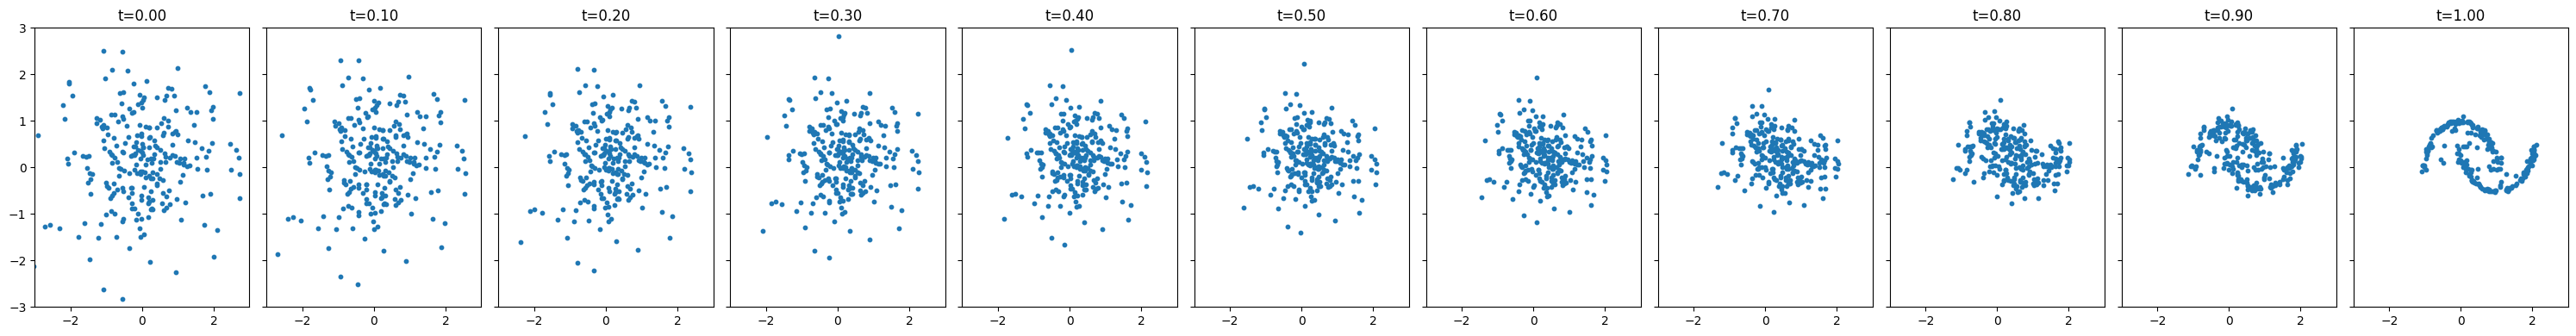

In [6]:
sample_flow_trough_time_2d(net_model)

## 1.2  MNIST

In [7]:
import torch.nn.functional as F

In [8]:
class UNetMNIST(nn.Module):
    def __init__(self, in_channels: int = 1, base_channels: int = 64):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels + 1, base_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.ELU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU()
        )
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels * 4, base_channels * 4, kernel_size=3, padding=1),
            nn.ELU()
        )
        # Decoder
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels * 6, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, kernel_size=3, padding=1),
            nn.ELU()
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels * 3, base_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.ELU(),
            nn.Conv2d(base_channels, 1, kernel_size=3, padding=1)
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Expand time tensor to match spatial dimensions
        b, c, h, w = x_t.shape
        t_expanded = t.expand(-1, 1, h, w)
        
        # Concatenate time as an additional channel
        x = torch.cat((x_t, t_expanded), dim=1)

        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc2, 2))
        
        # Decoder with skip connections
        dec2 = self.dec2(torch.cat([F.interpolate(bottleneck, scale_factor=2, mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=False), enc1], dim=1))
        
        return dec1

    def step(self, x_t: torch.Tensor, t_start: torch.Tensor, t_end: torch.Tensor) -> torch.Tensor:
        dt = t_end - t_start
        v_mid = self(x_t + self(x_t, t_start) * dt / 2, t_start + dt / 2)
        return x_t + dt * v_mid

In [17]:
batch_size = 32

dataset = datasets.MNIST(
    root="./data_mnist",
    train=True, 
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

# Filter the dataset to include only classes 1 and 7
#subset_indices = [i for i, (img, label) in enumerate(dataset) if label in [1, 7]]
#subset_indices = np.random.choice(subset_indices, size=1000, replace=False).tolist()
#dataset_subset = torch.utils.data.Subset(dataset, subset_indices)

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True, 
)

num_channels = 32  # Reduced from 128 since MNIST is simpler
num_res_blocks = 1

#net_model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
net_model = UNetMNIST(in_channels=1).to(device)


In [18]:
# Rest of the training loop
lr = 2e-4
optimizer = torch.optim.Adam(net_model.parameters())
loss_fn = nn.MSELoss()
otfm = OTFM()
sigma_min = 0
n_epochs = 50

for epoch in range(n_epochs):

    running_loss = 0.0
    
    for batch, _ in dataloader:
        batch = batch.to(device)
        
        x_0 = torch.randn_like(batch).to(device)
        x_1 = batch
        t = torch.rand(len(batch), 1, 28, 28).to(device)
        
        dx_t = otfm.compute_dx_t(x_0, x_1, sigma_min)
        x_t = otfm.compute_x_t(x_0, x_1, sigma_min, t)  
        
        
        optimizer.zero_grad()
        v_pred = net_model(x_t, t)
        loss = loss_fn(v_pred, dx_t)
        loss.backward()        
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(dataloader)}")

Epoch 1/50, Loss: 7.9506702983061475
Epoch 2/50, Loss: 0.44380355165799457
Epoch 3/50, Loss: 0.3556647673765818
Epoch 4/50, Loss: 0.28201700518131256
Epoch 5/50, Loss: 0.23260120687484742
Epoch 6/50, Loss: 0.20096709093252818
Epoch 7/50, Loss: 0.18137348111470541
Epoch 8/50, Loss: 0.16916893781820933
Epoch 9/50, Loss: 0.15930211992263793
Epoch 10/50, Loss: 0.15087296782334644
Epoch 11/50, Loss: 0.14399851007461548
Epoch 12/50, Loss: 0.13801898425420125
Epoch 13/50, Loss: 0.13344126089016597
Epoch 14/50, Loss: 0.12988454835414887
Epoch 15/50, Loss: 0.1269498841325442
Epoch 16/50, Loss: 0.12502493007183074
Epoch 17/50, Loss: 0.12301908819278082
Epoch 18/50, Loss: 0.12151000589927037
Epoch 19/50, Loss: 0.1205025557200114
Epoch 20/50, Loss: 0.1191244753797849
Epoch 21/50, Loss: 0.11826088406642278
Epoch 22/50, Loss: 0.11740325937271118
Epoch 23/50, Loss: 0.11649332996606827
Epoch 24/50, Loss: 0.11615444317658742
Epoch 25/50, Loss: 0.11527606949408849
Epoch 26/50, Loss: 0.11469067637523016


In [19]:
from matplotlib import pyplot as plt

In [20]:
class FlowMatchingSampler:
    def __init__(self, net_model, device='cuda'):
        self.net_model = net_model
        self.device = device

    def visualize_mnist_flow(self,model, n_samples=10, n_steps=8, device='cuda'):
        """
        Visualize the flow from noise to MNIST-like images.
        
        Args:
            model: The trained UNet model
            n_samples: Number of images to generate
            n_steps: Number of intermediate steps to show
            device: Device to run the model on
        """

        model.eval()
        
        # Generate initial random noise
        x = torch.randn(n_samples, 1, 28, 28).to(device)
        
        # Create subplots
        fig, axes = plt.subplots(n_samples, n_steps + 1, figsize=(2*(n_steps + 1), 2*n_samples))
        time_steps = torch.linspace(0, 1.0, n_steps + 1)
        
        # Plot initial noise samples
        for j in range(n_samples):
            axes[j, 0].imshow(x[j, 0].cpu().detach(), cmap='gray')
            axes[j, 0].axis('off')
        axes[0, 0].set_title(f't={time_steps[0]:.2f}')
        
        # Perform steps and plot samples at each step
        with torch.no_grad():
            for i in range(n_steps):
                t_start = torch.tensor([time_steps[i]], device=device).view(1, 1, 1, 1).expand(n_samples, -1, -1, -1)
                t_end = torch.tensor([time_steps[i + 1]], device=device).view(1, 1, 1, 1).expand(n_samples, -1, -1, -1)
                
                x = model.step(x, t_start, t_end)
                
                # Plot each sample
                for j in range(n_samples):
                    axes[j, i + 1].imshow(x[j, 0].cpu().detach(), cmap='gray')
                    axes[j, i + 1].axis('off')
                axes[0, i + 1].set_title(f't={time_steps[i + 1]:.2f}')
        
        plt.tight_layout()
        plt.show()
        
    def vector_field(self, t, x):
        """Vector field for ODE solver"""
        # Reshape t to match MNIST dimensions (1 channel, 28x28)
        t_shaped = t.reshape(1, 1, 1, 1).expand(x.shape[0], 1, 28, 28).to(self.device)
        return self.net_model(t_shaped, x)
    
    def generate_samples(self, num_samples, rtol=1e-5, atol=1e-5):
        """
        Generate samples using the trained flow matching model
        
        Args:
            num_samples: Number of samples to generate
            rtol: Relative tolerance for ODE solver
            atol: Absolute tolerance for ODE solver
        """
        # Initial noise - adapted for MNIST dimensions
        x_0 = torch.randn(num_samples, 1, 28, 28).to(self.device)
        
        # Time points for integration
        t = torch.linspace(0, 1, 2).to(self.device)
        
        # Solve ODE
        self.net_model.eval()
        with torch.no_grad():
            samples = odeint(
                self.vector_field,
                x_0,
                t,
                method='dopri5',
                rtol=rtol,
                atol=atol
            )
        
        # Return final samples (at t=1)
        return samples[-1]

def save_samples(samples, filename):
    """Helper function to save generated samples"""
    # Ensure samples are in correct range [0, 1]
    samples = torch.clamp(samples, 0, 1)
    # Save as grid of images
    torchvision.utils.save_image(
        samples,
        filename,
        nrow=int(np.sqrt(len(samples))),
        normalize=True
    )

# Usage example:
sampler = FlowMatchingSampler(net_model, device=device)
num_samples = 16  # Generate a 4x4 grid of samples
samples = sampler.generate_samples(num_samples)
save_samples(samples, "mnist_samples.png")

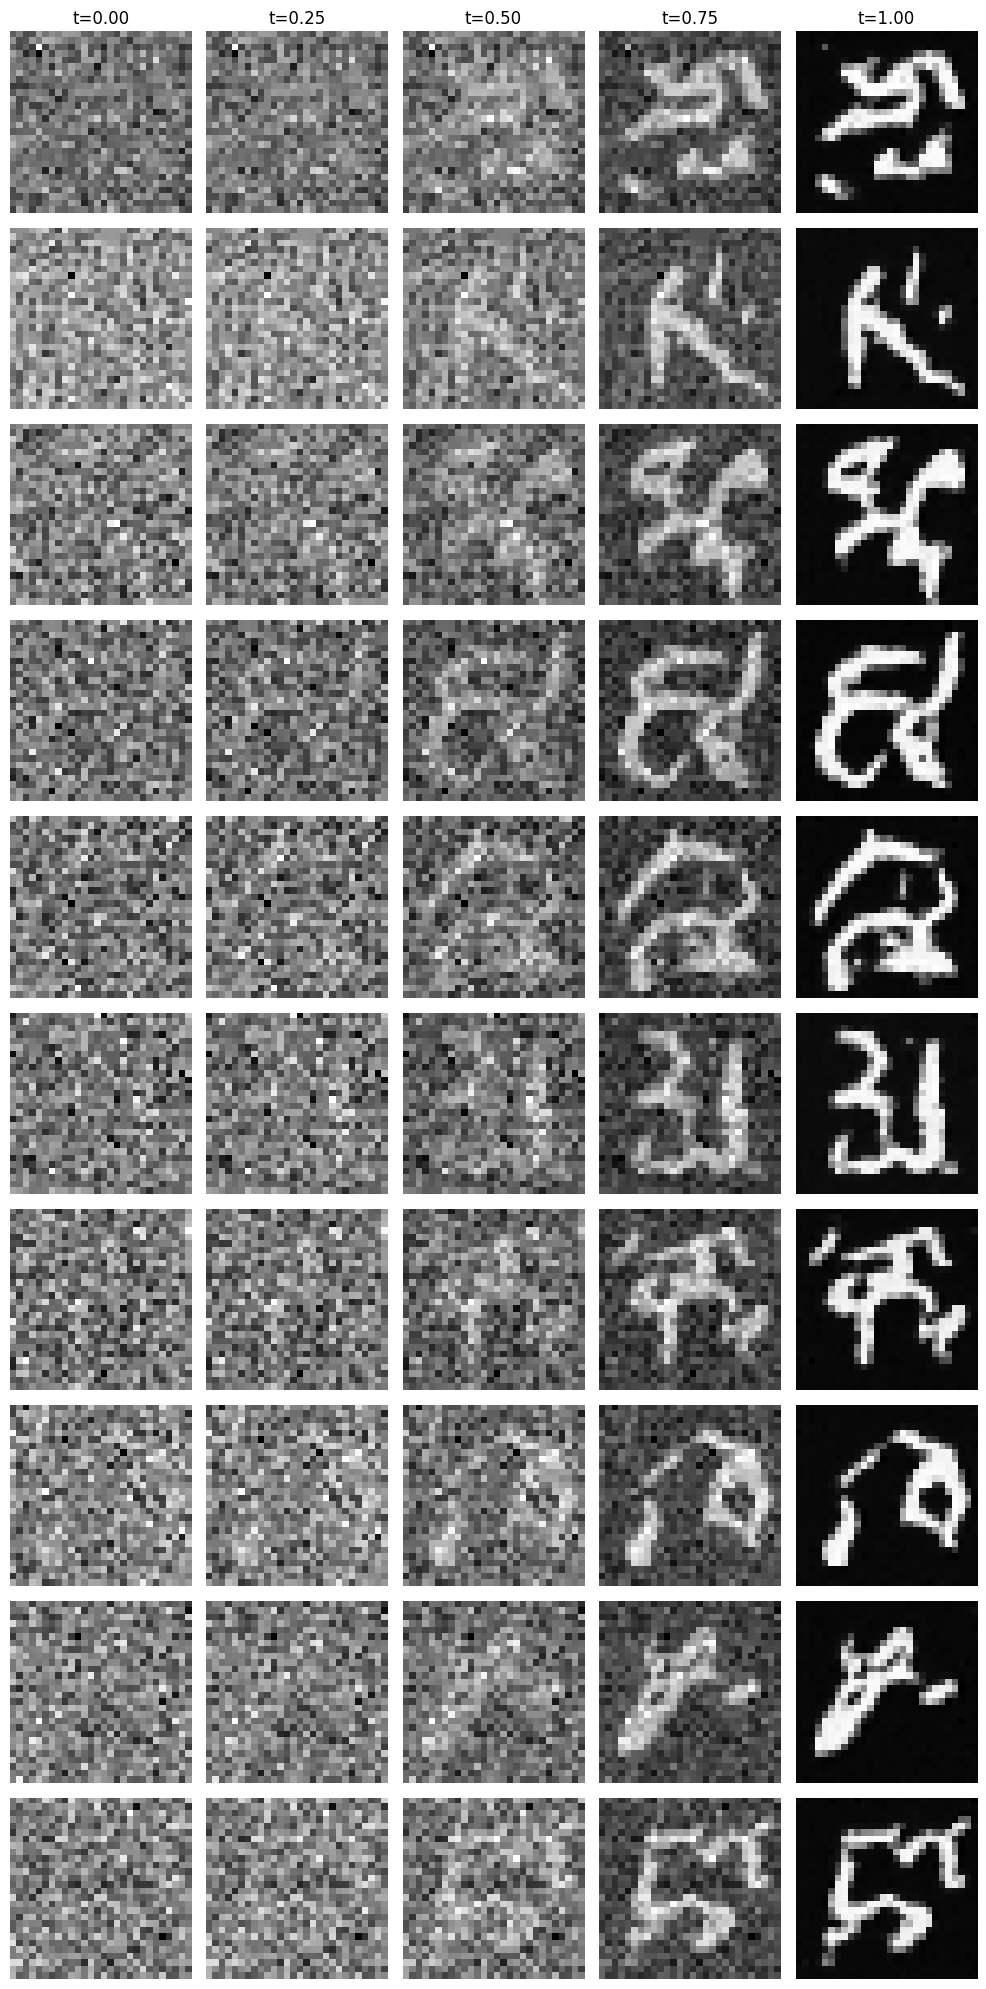

In [21]:
sampler.visualize_mnist_flow(net_model, n_samples=10, n_steps=4, device=device)

## 1.3 Checkboards

## 1.4 CIFAR10

We start by implemeting the flow matching and applying it to the CIFAR10 (Krizhevsky et al., 2009) dataset. As in Lipman et al., 2023, we evaluate likelihood and samples from the model using dopri5 (Dormand & Prince, 1980).

In [4]:
batch_size = 128
num_channel = 128
num_workers = 4
lr = 2e-4

In [16]:
dataset = datasets.CIFAR10(
    root="./data_cifar10",
    train=True, 
    download=True, 
    transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
)

subset_indices = list(range(256))  # Use the first 256 samples
dataset_subset = torch.utils.data.Subset(dataset, subset_indices)

dataloader = torch.utils.data.DataLoader(
    dataset_subset, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True, 
)

Files already downloaded and verified


In [17]:
net_model = UNetModelWrapper(
    dim=(3, 32, 32),
    num_res_blocks=2,
    num_channels=num_channel,
    channel_mult=[1, 2, 2, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="16",
    dropout=0.1,
).to(
    device
)

In [36]:
# training
optmizer = torch.optim.Adam(net_model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
otfm = OTFM()
sigma_min = 0.001
n_epochs = 10

for epoch in range(n_epochs):
    net_model.train()
    running_loss = 0.0
    
    print("epoch: ", epoch)
    
    for batch, _ in dataloader:
        
        batch = batch.to(device)
        
        x_0 = torch.randn_like(batch).to(device)

        x_1 = batch

        t = torch.rand(len(batch), 3, 32, 32).to(device)
        
        x_t = otfm.compute_x_t(x_0, x_1, sigma_min)
        dx_t = otfm.compute_dx_t(x_0, x_1, sigma_min, t)
        
        optmizer.zero_grad()
        
        loss = loss_fn(net_model(t, x_t), dx_t)
        
        loss.backward()        
        optmizer.step()
        
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(dataloader)}")

epoch:  0
Epoch 1/10, Loss: 0.17949417233467102
epoch:  1
Epoch 2/10, Loss: 0.17611891776323318
epoch:  2
Epoch 3/10, Loss: 0.1601923257112503
epoch:  3
Epoch 4/10, Loss: 0.16158664971590042
epoch:  4
Epoch 5/10, Loss: 0.15941228717565536
epoch:  5
Epoch 6/10, Loss: 0.15786418318748474
epoch:  6
Epoch 7/10, Loss: 0.1569773033261299
epoch:  7
Epoch 8/10, Loss: 0.15630418807268143
epoch:  8
Epoch 9/10, Loss: 0.15595542639493942
epoch:  9
Epoch 10/10, Loss: 0.1557096466422081


In [37]:

class FlowMatchingSampler:
    def __init__(self, net_model, device='cuda'):
        self.net_model = net_model
        self.device = device
        
    def vector_field(self, t, x):
        """Vector field for ODE solver"""
        # Reshape t to match the expected input shape of the model
        t_shaped = t.reshape(1, 1, 1, 1).expand(x.shape[0], 3, 32, 32).to(self.device)
        return self.net_model(t_shaped, x)
    
    def generate_samples(self, num_samples, rtol=1e-5, atol=1e-5):
        """
        Generate samples using the trained flow matching model
        
        Args:
            num_samples: Number of samples to generate
            rtol: Relative tolerance for ODE solver
            atol: Absolute tolerance for ODE solver
        """
        # Initial noise
        x_0 = torch.randn(num_samples, 3, 32, 32).to(self.device)
        
        # Time points for integration
        t = torch.linspace(0, 1, 2).to(self.device)
        
        # Solve ODE
        self.net_model.eval()
        with torch.no_grad():
            samples = odeint(
                self.vector_field,
                x_0,
                t,
                method='dopri5',
                rtol=rtol,
                atol=atol
            )
        
        # Return final samples (at t=1)
        return samples[-1]

def save_samples(samples, filename):
    """Helper function to save generated samples"""
    # Ensure samples are in correct range [0, 1]
    samples = torch.clamp(samples, 0, 1)
    # Save as grid of images
    torchvision.utils.save_image(
        samples,
        filename,
        nrow=int(np.sqrt(len(samples))),
        normalize=True
    )



In [40]:
# Initialize sampler
sampler = FlowMatchingSampler(net_model, device=device)

# Generate samples
num_samples = 4
samples = sampler.generate_samples(num_samples)

# Save samples
save_samples(samples, "flow_matching_samples.png")


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[4, 3, 32, 32] to have 1 channels, but got 3 channels instead

epoch:  0


KeyboardInterrupt: 